In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

from venn_abers import VennAbersCalibrator
from mapie.metrics.calibration import expected_calibration_error

In [4]:
def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return expected_calibration_error(y, p, num_bins=n_bins, split_strategy="quantile"), pt, pp

# def ece_quantile(y, p, n_bins=10):
#     return expected_calibration_error(y, p, num_bins=n_bins, split_strategy="quantile")


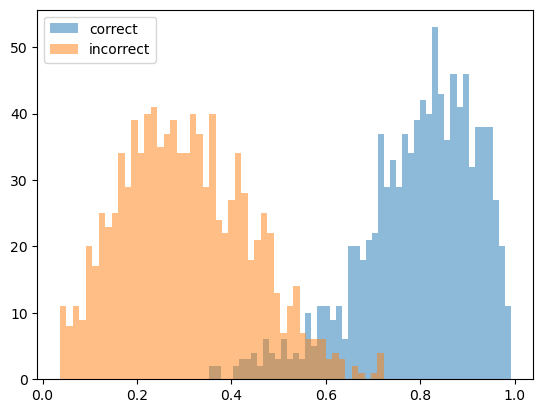

In [19]:
rng = np.random.default_rng(42)
# # for class 0
# plt.hist(rng.beta(2, 8, size=1000), bins=50, alpha=0.5, label='correct')
# plt.hist(rng.beta(7, 3, size=1000), bins=50, alpha=0.5, label='incorrect')
# plt.show()

# for class 1
plt.hist(rng.beta(8, 2, size=1000), bins=50, alpha=0.5, label='correct')
plt.hist(rng.beta(3, 7, size=1000), bins=50, alpha=0.5, label='incorrect')
plt.legend()
plt.show()

In [31]:
def run_simulation(counts, title="Simulation"):
    rng = np.random.default_rng(42)


    # # Class 0: mixture of two Betas(2,5) and (1,8)
    # probs_0 = 0.7 * rng.beta(2, 8, size=counts[0]) + 0.3 * rng.beta(1, 8, size=counts[0]) * rng.choice([-1, 1], size=counts[0])
    # probs_0 = np.clip(probs_0, 0, 1)
    
    # rng = np.random.default_rng(0)
    # # Class 1: mixture of two Betas(10,5) and (1,8)
    # probs_1 = 0.7 * rng.beta(8, 2, size=counts[1]) + 0.3 * rng.beta(1, 8, size=counts[1]) * rng.choice([-1, 1], size=counts[1])
    # probs_1 = np.clip(probs_1, 0, 1)

    # Calculate the number of samples for each component
    n0_correct = int(0.7 * counts[0])  # 70% of Class 0 are correct predictions
    n0_error = counts[0] - n0_correct   # 30% of Class 0 are overconfident errors

    n1_correct = int(0.7 * counts[1])  # 70% of Class 1 are correct predictions
    n1_error = counts[1] - n1_correct   # 30% of Class 1 are underconfident errors

    # Class 0: mixture of two Betas(2,5) and (1,8)
    # probs_0 = 0.7 * rng.beta(2, 8, size=counts[0]) + 0.3 * rng.beta(7, 3, size=counts[0])
    probs_0 = np.concatenate([
        rng.beta(2, 8, size=n0_correct),   # Correct predictions (low scores)
        rng.beta(7, 3, size=n0_error)    # Overconfident errors (high scores)
    ])
    probs_0 = np.clip(probs_0, 0, 1)
    # print(probs_0.shape)
    
    rng = np.random.default_rng(0)
    # Class 1: mixture of two Betas(10,5) and (1,8)
    # probs_1 = 0.7 * rng.beta(8, 2, size=counts[1]) + 0.3 * rng.beta(3, 7, size=counts[1])
    probs_1 = np.concatenate([
        rng.beta(8, 2, size=n1_correct),   # Correct predictions (high scores)
        rng.beta(3, 7, size=n1_error)    # Underconfident errors (low scores)
    ])
    probs_1 = np.clip(probs_1, 0, 1)
    # print(probs_1.shape)

    df_sim = pd.DataFrame({
        "y": np.concatenate([np.zeros(n0_correct + n0_error, int), np.ones(n1_correct + n1_error, int)]),
        "proba": np.concatenate([probs_0, probs_1])
    }).sample(frac=1, random_state=42).reset_index(drop=True)

    plt.figure(figsize=(8,5))
    sns.histplot(df_sim[df_sim["y"]==0]["proba"], bins=30, color="blue", label="Class 0", stat="density", alpha=0.5)
    sns.histplot(df_sim[df_sim["y"]==1]["proba"], bins=30, color="red", label="Class 1", stat="density", alpha=0.5)

    sns.kdeplot(df_sim[df_sim["y"]==0]["proba"], color="blue", lw=2)
    sns.kdeplot(df_sim[df_sim["y"]==1]["proba"], color="red", lw=2)

    plt.xlabel("Model's Scores")
    plt.ylabel("Density")
    plt.title(f"Model's Scores by Class {title}")
    plt.legend()
    plt.show()

    # print(f"\n=== {title} ===")
    # print(df_sim.groupby("y")["proba"].describe())

    # ---- Calibration split ----
    X_cal, X_test, y_cal, y_test = train_test_split(
        df_sim[["proba"]].values, df_sim["y"].values,
        test_size=0.3, stratify=df_sim["y"].values, random_state=42
    )
    s_cal, s_test = X_cal.ravel(), X_test.ravel()

    # ---- Platt ----
    p_platt_test, _ = platt_fit_predict(s_cal, y_cal, s_test)
    p_platt_cal, _  = platt_fit_predict(s_cal, y_cal, s_cal)

    # ---- Isotonic ----
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(s_cal, y_cal)
    p_iso_test, p_iso_cal = iso.predict(s_test), iso.predict(s_cal)

    # ---- Venn-Abers ----
    p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
    p_test_2d = np.column_stack([1 - s_test, s_test])
    va = VennAbersCalibrator()
    p_va_test = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                 p_test=p_test_2d, p0_p1_output=False)[:,1]
    p_va_cal = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                p_test=p_cal_2d, p0_p1_output=False)[:,1]

    # ---- Results ----
    methods_test = {
        "Raw": s_test,
        "Platt": p_platt_test,
        "Isotonic": p_iso_test,
        "Venn-Abers-IVAP": p_va_test,
    }
    methods_cal = {
        "Raw": s_cal,
        "Platt": p_platt_cal,
        "Isotonic": p_iso_cal,
        "Venn-Abers-IVAP": p_va_cal,
    }

    def evaluate(methods, y, setname):
        rows = []
        for name, p in methods.items():
            ece, _, _ = ece_quantile(y, p, n_bins=10)
            rows.append({
                "Method": name,
                "LogLoss": round(log_loss(y, p), 3),
                "Brier": round(brier_score_loss(y, p), 3),
                "ROC_AUC": round(roc_auc_score(y, p), 3),
                "ECE": round(ece, 3),
            })
        df = pd.DataFrame(rows).set_index("Method").round(4)
        print(f"\nCalibration Metrics ({setname} set):")
        display(df)

    # --- Metrics ---
    evaluate(methods_cal,  y_cal,  "Calibration")
    evaluate(methods_test, y_test, "Test")

    # --- Calibration curves: CAL set ---
    plt.figure(figsize=(6,6))
    max_pp = []
    max_pt = []
    for name, p in methods_cal.items():
        _, pt, pp = ece_quantile(y_cal, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
        max_pp.append(max(pp))
        max_pt.append(max(pt))

    plt.plot([0,max(max(max_pp), max(max_pt))],[0,max(max(max_pp), max(max_pt))],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Calibration set) - {title}")
    plt.legend(); plt.grid(True); plt.show()

    # --- Calibration curves: TEST set ---
    plt.figure(figsize=(6,6))
    max_pp = []
    max_pt = []
    for name, p in methods_test.items():
        _, pt, pp = ece_quantile(y_test, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
        max_pp.append(max(pp))
        max_pt.append(max(pt))

    plt.plot([0,max(max(max_pp), max(max_pt))],[0,max(max(max_pp), max(max_pt))],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Test set) - {title}")
    plt.legend(); plt.grid(True); plt.show()


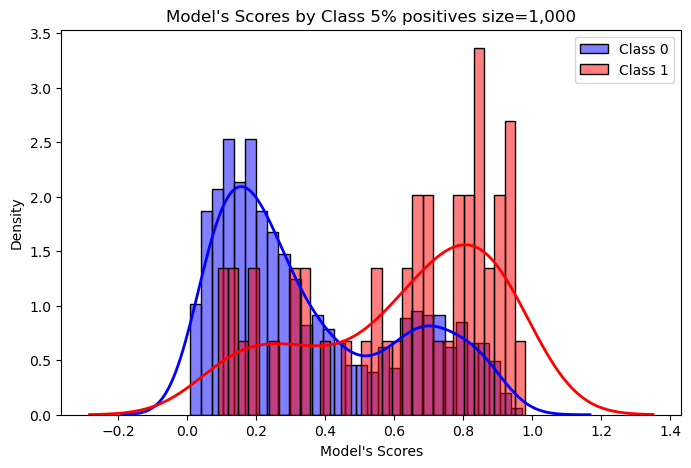


Calibration Metrics (Calibration set):


c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.567,0.193,0.772,0.319
Platt,0.173,0.044,0.772,0.014
Isotonic,0.163,0.042,0.801,0.000
Venn-Abers-IVAP,0.169,0.043,0.793,0.013



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.559,0.190,0.746,0.309
Platt,0.175,0.043,0.746,0.015
Isotonic,0.279,0.043,0.724,0.015
Venn-Abers-IVAP,0.176,0.043,0.739,0.015


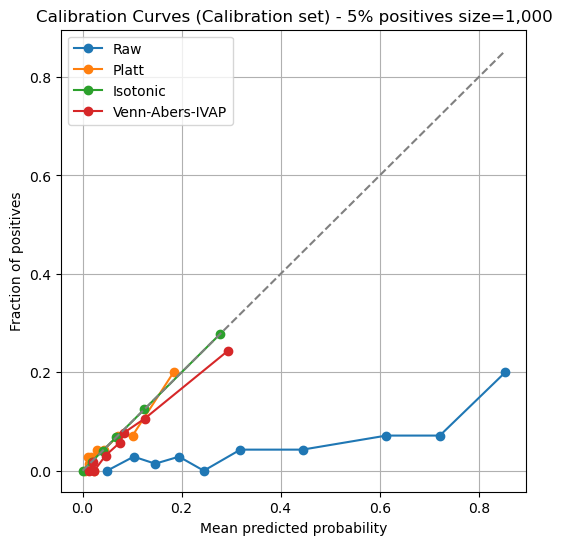

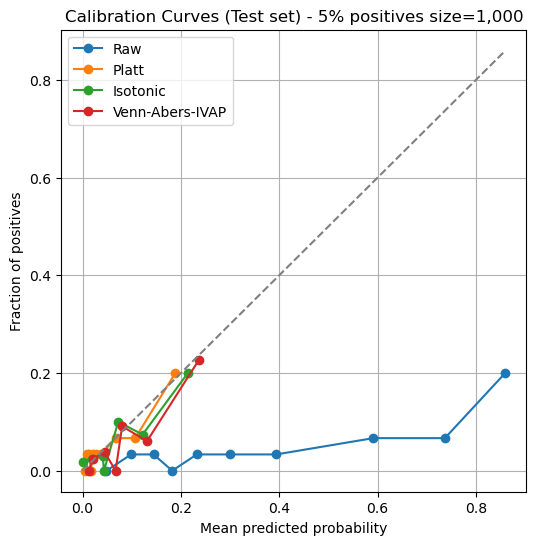

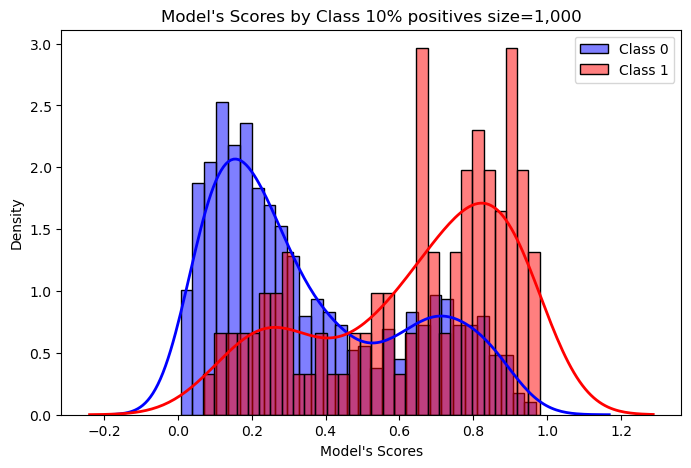


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.539,0.183,0.787,0.271
Platt,0.271,0.078,0.787,0.010
Isotonic,0.260,0.075,0.803,0.000
Venn-Abers-IVAP,0.265,0.075,0.799,0.014



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.609,0.206,0.783,0.302
Platt,0.275,0.079,0.783,0.042
Isotonic,0.283,0.082,0.789,0.050
Venn-Abers-IVAP,0.281,0.081,0.787,0.048


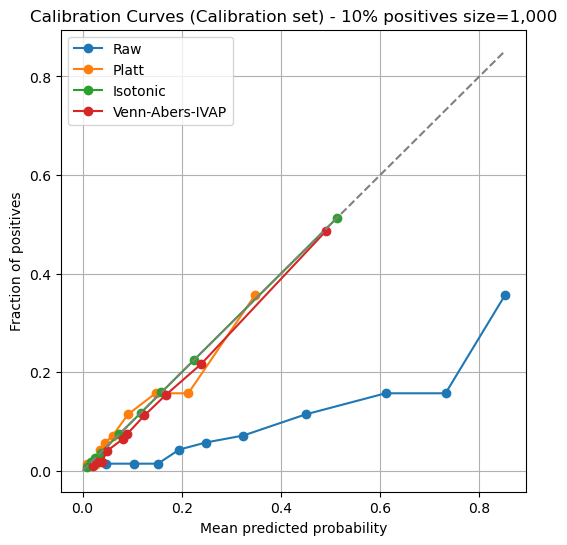

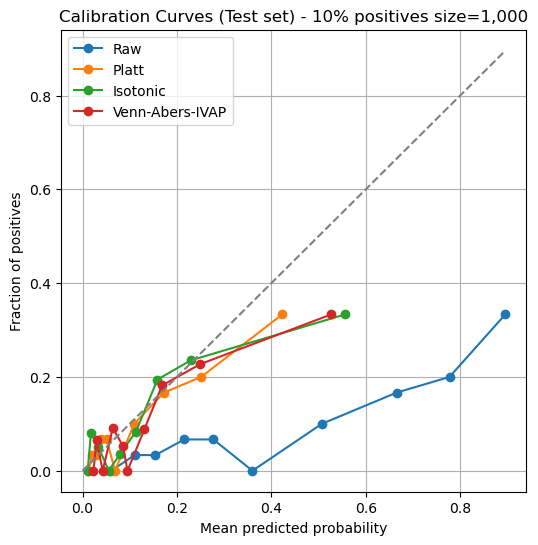

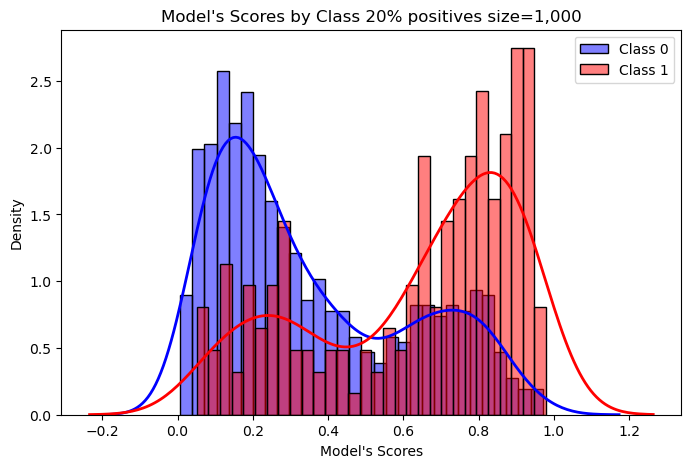


Calibration Metrics (Calibration set):


c:\Users\User\.conda\envs\classification_calibration\lib\site-packages\venn_abers\venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.578,0.196,0.751,0.199
Platt,0.430,0.135,0.751,0.036
Isotonic,0.411,0.129,0.769,0.000
Venn-Abers-IVAP,0.416,0.130,0.766,0.009



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.566,0.190,0.814,0.232
Platt,0.398,0.124,0.814,0.052
Isotonic,0.401,0.125,0.799,0.035
Venn-Abers-IVAP,0.405,0.126,0.803,0.052


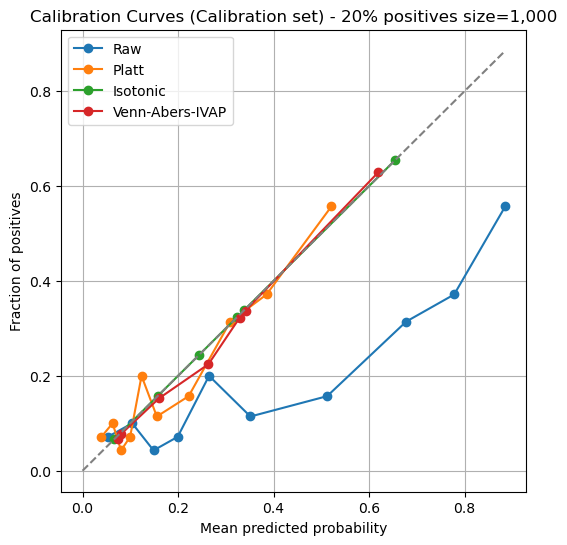

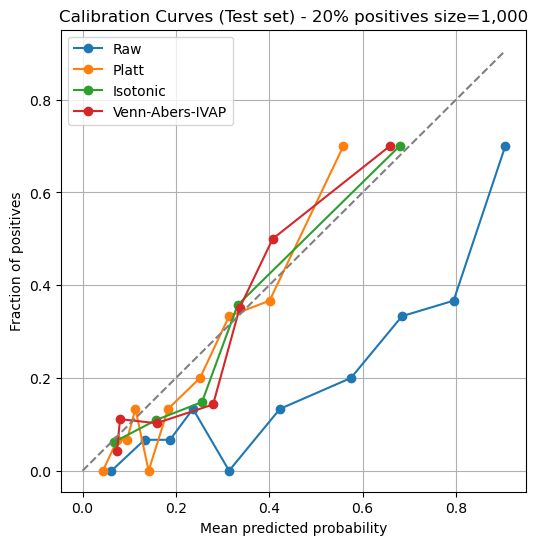

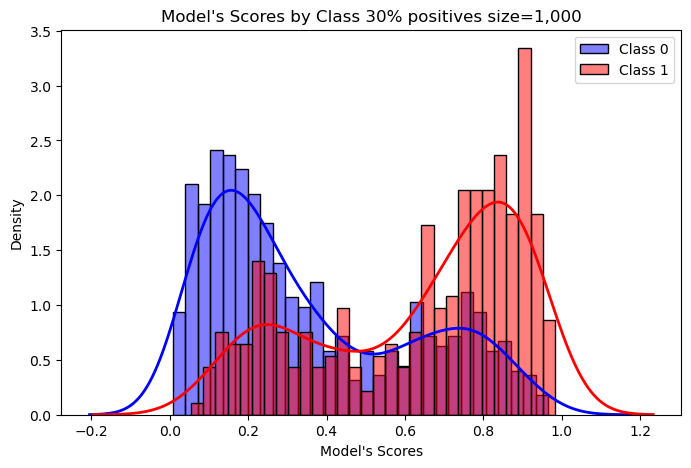


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.575,0.196,0.776,0.140
Platt,0.504,0.167,0.776,0.026
Isotonic,0.488,0.162,0.786,0.000
Venn-Abers-IVAP,0.494,0.163,0.785,0.013



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.573,0.194,0.788,0.140
Platt,0.497,0.165,0.788,0.037
Isotonic,0.720,0.166,0.785,0.032
Venn-Abers-IVAP,0.495,0.164,0.785,0.025


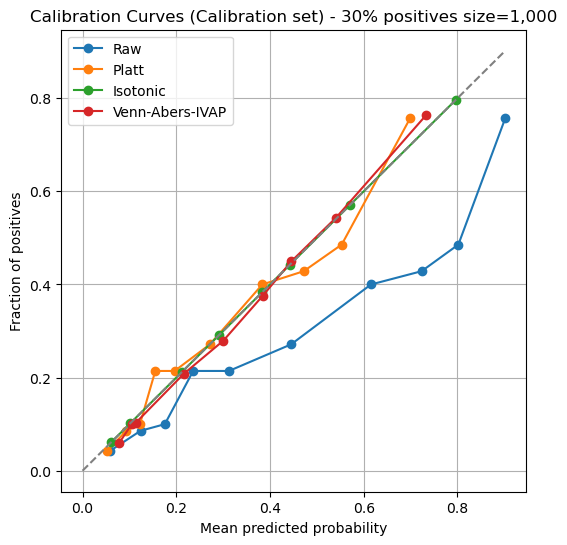

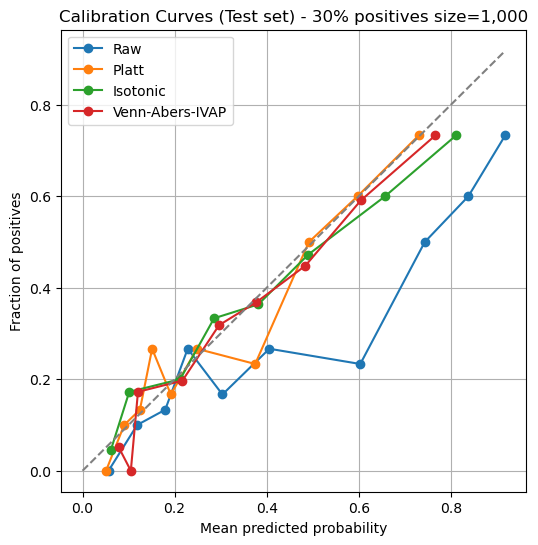

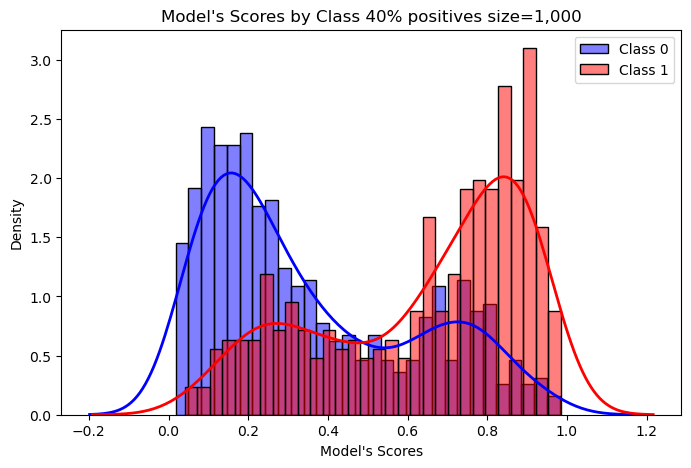


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.571,0.192,0.784,0.077
Platt,0.547,0.184,0.784,0.023
Isotonic,0.532,0.179,0.793,0.000
Venn-Abers-IVAP,0.537,0.180,0.792,0.014



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.555,0.188,0.801,0.083
Platt,0.533,0.178,0.801,0.059
Isotonic,0.637,0.177,0.802,0.070
Venn-Abers-IVAP,0.529,0.177,0.802,0.066


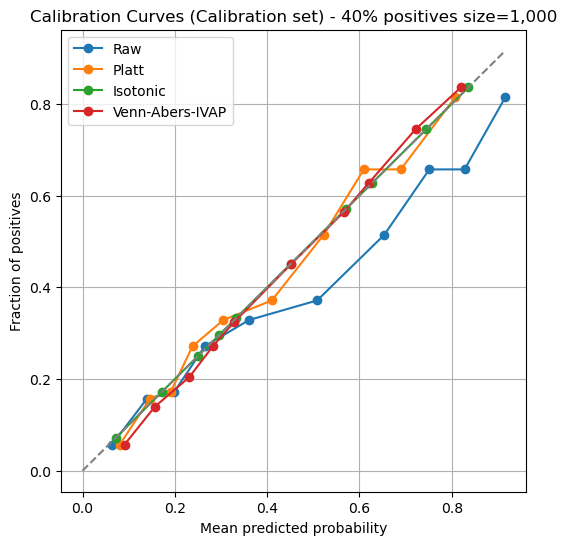

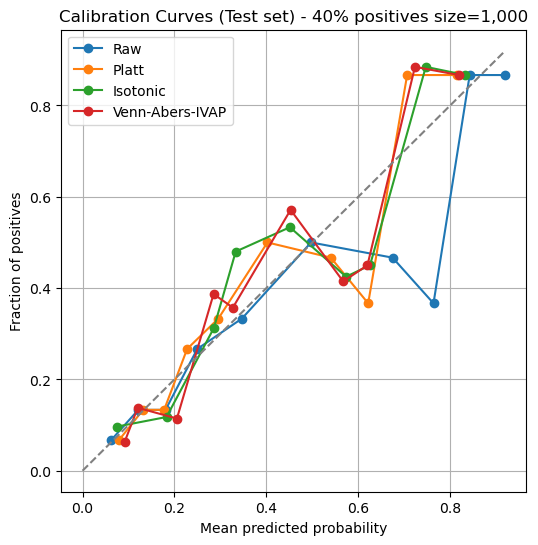

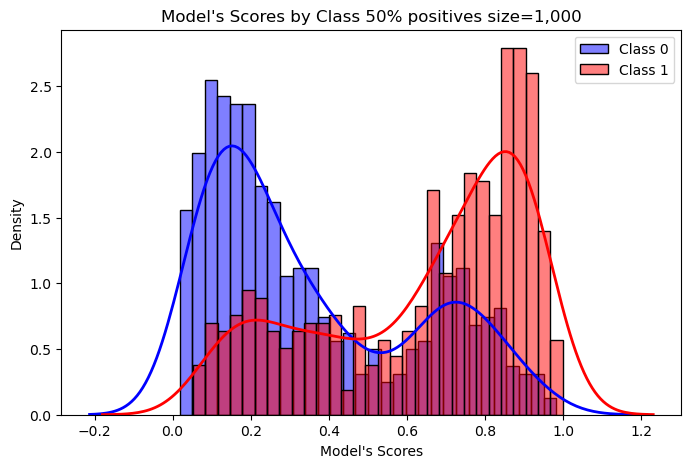


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.581,0.196,0.779,0.069
Platt,0.566,0.191,0.779,0.032
Isotonic,0.549,0.186,0.789,0.000
Venn-Abers-IVAP,0.554,0.187,0.787,0.014



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.581,0.199,0.779,0.090
Platt,0.566,0.193,0.779,0.067
Isotonic,0.563,0.193,0.777,0.073
Venn-Abers-IVAP,0.562,0.192,0.780,0.050


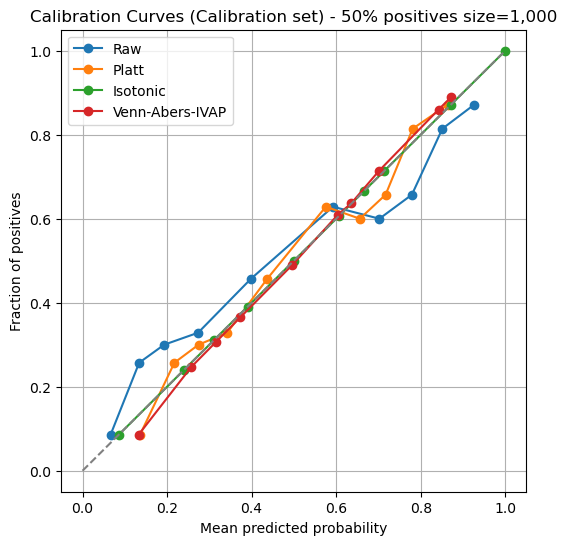

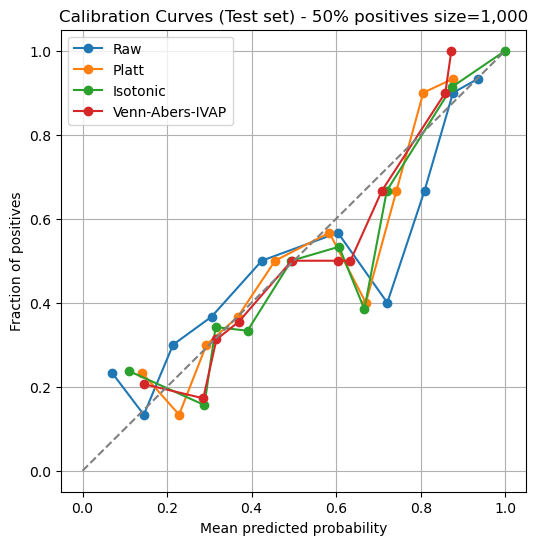

In [32]:
# Size of dataset: 1,000 samples
run_simulation({0: 950, 1: 50}, title="5% positives size=1,000")

run_simulation({0: 900, 1: 100}, title="10% positives size=1,000")

run_simulation({0: 800, 1: 200}, title="20% positives size=1,000")

run_simulation({0: 700, 1: 300}, title="30% positives size=1,000")

run_simulation({0: 600, 1: 400}, title="40% positives size=1,000")

run_simulation({0: 500, 1: 500}, title="50% positives size=1,000")

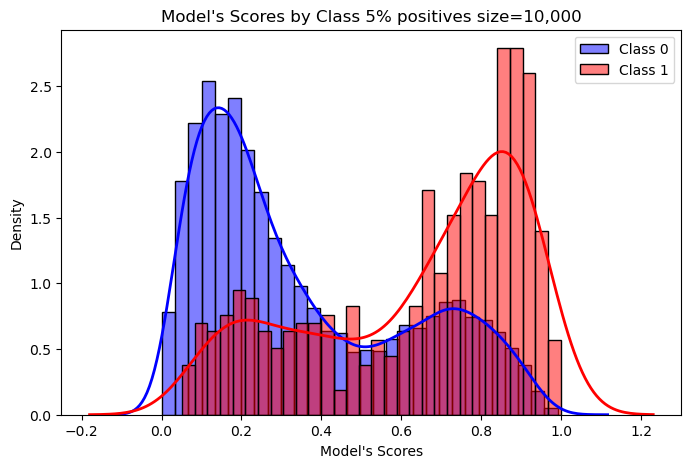


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.560,0.188,0.793,0.313
Platt,0.168,0.043,0.793,0.002
Isotonic,0.165,0.043,0.799,0.000
Venn-Abers-IVAP,0.166,0.043,0.798,0.003



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.562,0.191,0.759,0.312
Platt,0.176,0.044,0.759,0.008
Isotonic,0.176,0.044,0.756,0.008
Venn-Abers-IVAP,0.176,0.045,0.757,0.008


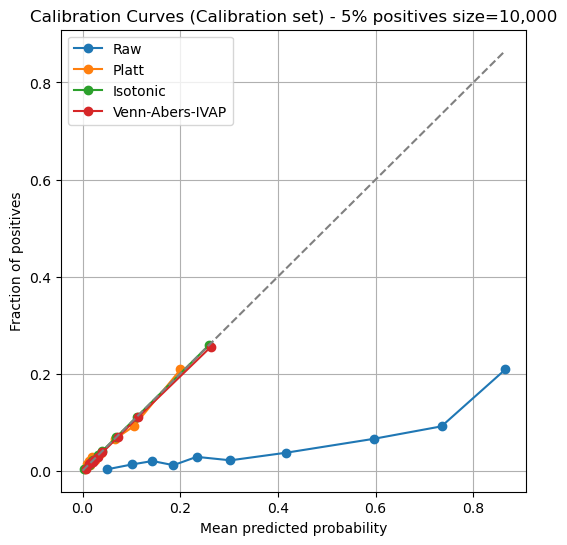

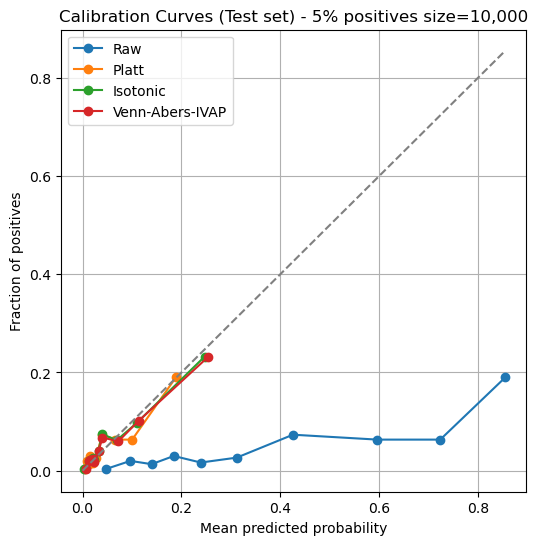

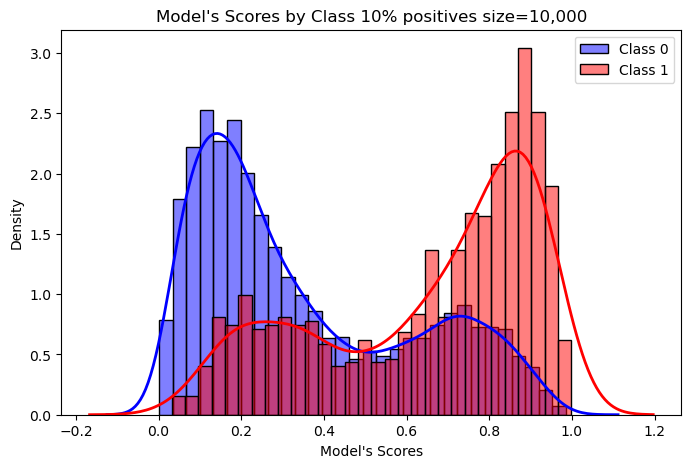


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.557,0.188,0.801,0.279
Platt,0.266,0.076,0.801,0.014
Isotonic,0.261,0.075,0.806,0.000
Venn-Abers-IVAP,0.262,0.075,0.805,0.002



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.561,0.190,0.783,0.277
Platt,0.274,0.078,0.783,0.013
Isotonic,0.274,0.079,0.782,0.011
Venn-Abers-IVAP,0.274,0.079,0.782,0.009


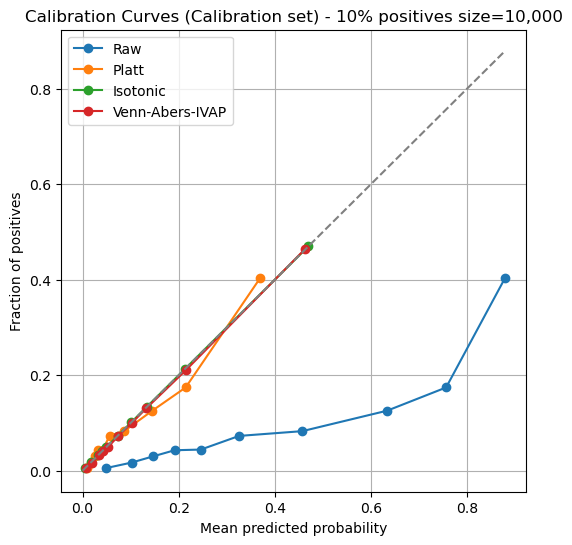

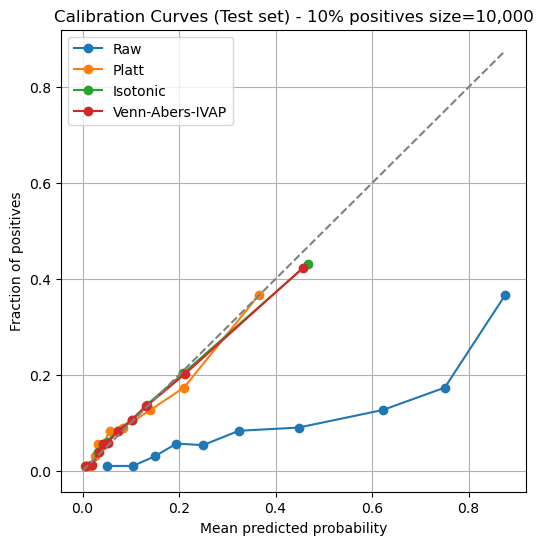

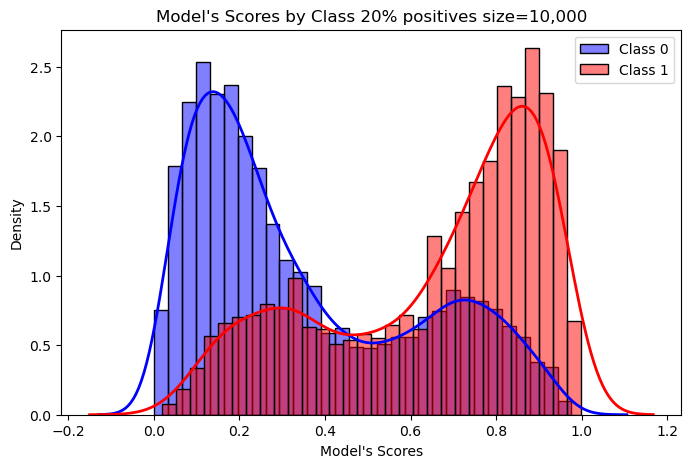


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.557,0.188,0.792,0.206
Platt,0.407,0.129,0.792,0.015
Isotonic,0.401,0.127,0.796,0.000
Venn-Abers-IVAP,0.402,0.127,0.796,0.003



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.560,0.190,0.810,0.218
Platt,0.395,0.124,0.810,0.021
Isotonic,0.395,0.125,0.808,0.013
Venn-Abers-IVAP,0.395,0.125,0.809,0.015


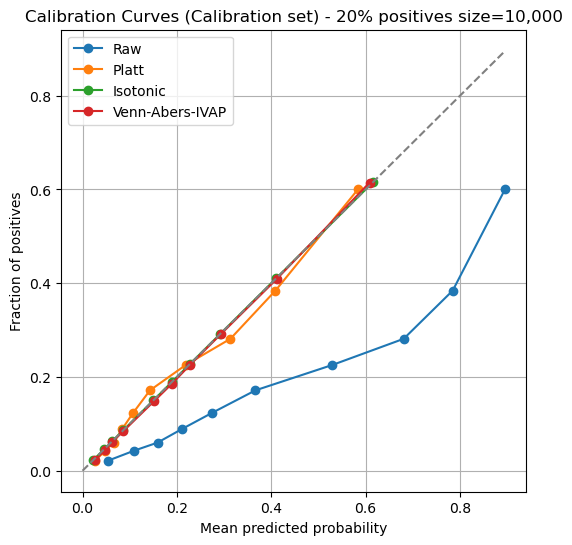

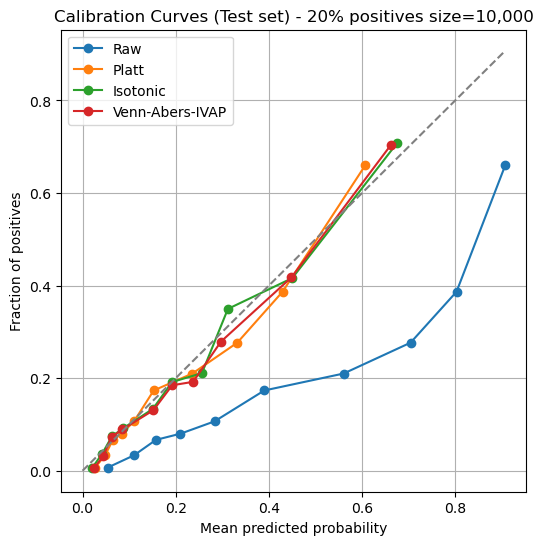

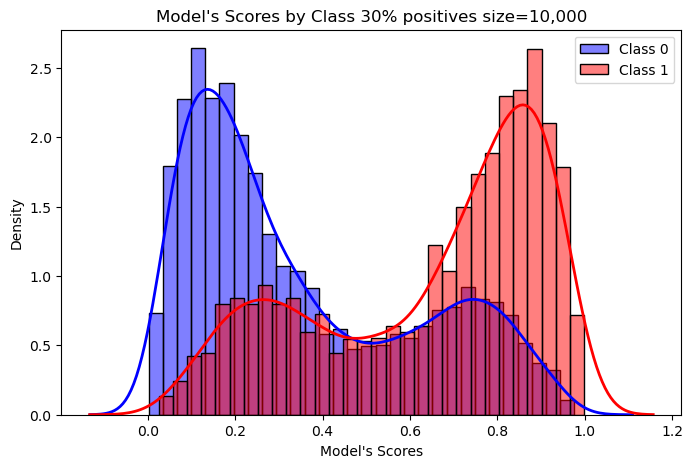


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.567,0.193,0.785,0.136
Platt,0.498,0.165,0.785,0.033
Isotonic,0.490,0.162,0.787,0.000
Venn-Abers-IVAP,0.491,0.162,0.787,0.003



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.551,0.184,0.807,0.143
Platt,0.478,0.157,0.807,0.021
Isotonic,0.490,0.157,0.806,0.024
Venn-Abers-IVAP,0.479,0.157,0.807,0.023


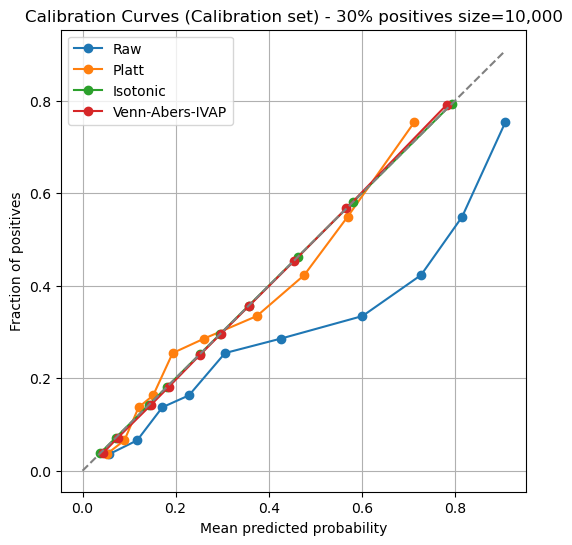

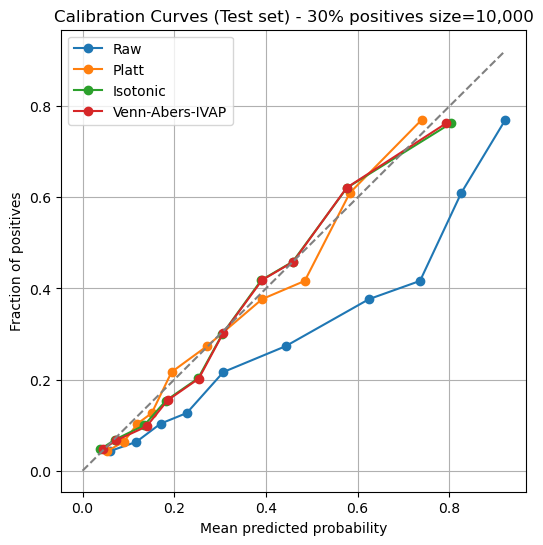

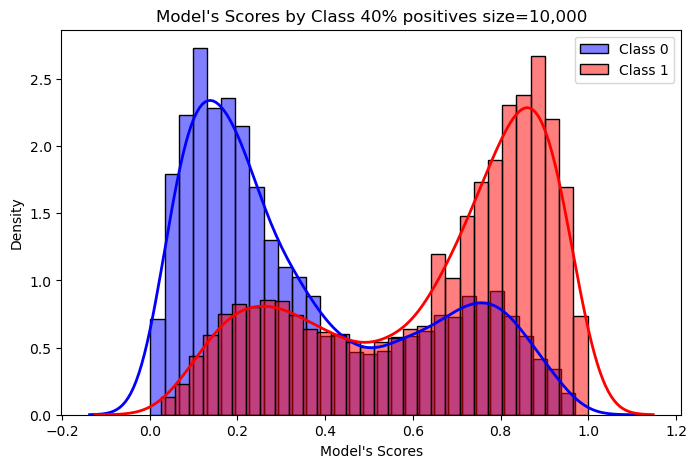


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.562,0.190,0.793,0.071
Platt,0.537,0.181,0.793,0.029
Isotonic,0.529,0.178,0.795,0.000
Venn-Abers-IVAP,0.530,0.178,0.795,0.003



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.574,0.195,0.782,0.075
Platt,0.547,0.184,0.782,0.016
Isotonic,0.549,0.185,0.781,0.012
Venn-Abers-IVAP,0.549,0.185,0.781,0.011


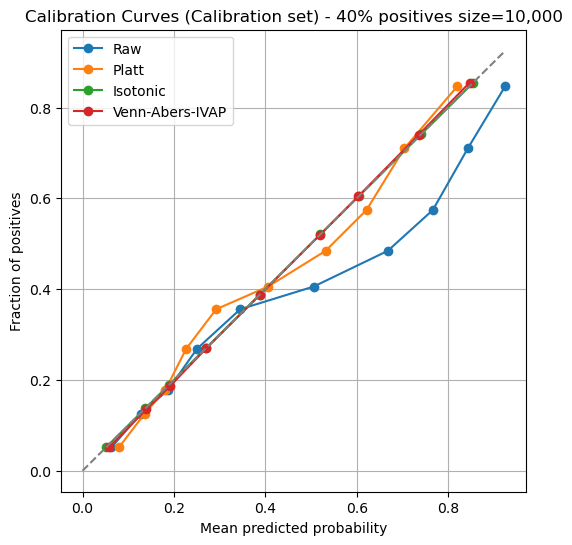

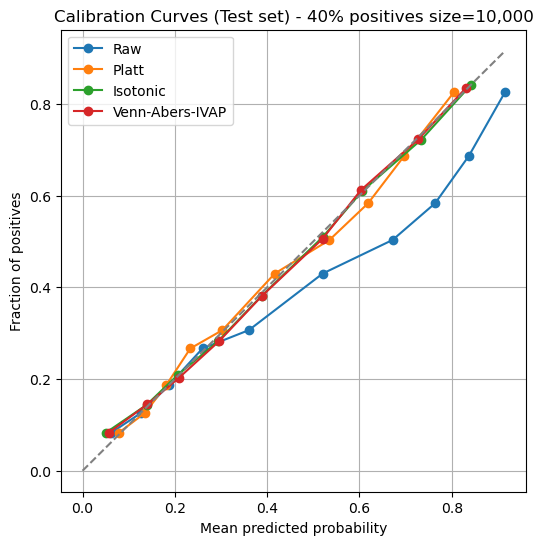

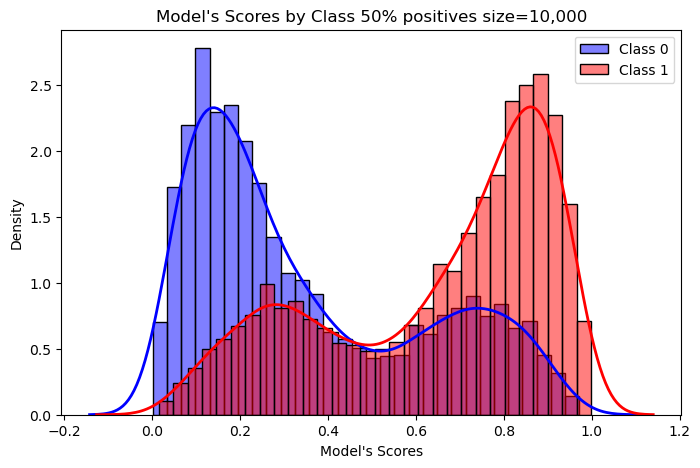


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.562,0.190,0.792,0.057
Platt,0.553,0.187,0.792,0.023
Isotonic,0.546,0.184,0.795,0.000
Venn-Abers-IVAP,0.547,0.184,0.794,0.003



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.568,0.192,0.789,0.063
Platt,0.558,0.189,0.789,0.031
Isotonic,0.555,0.187,0.789,0.020
Venn-Abers-IVAP,0.555,0.187,0.789,0.019


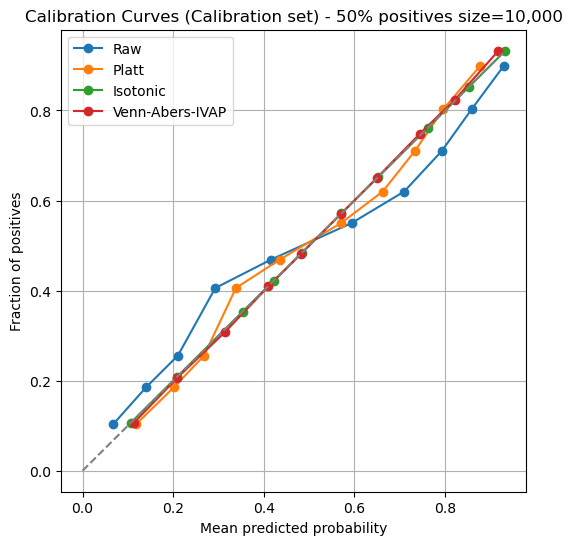

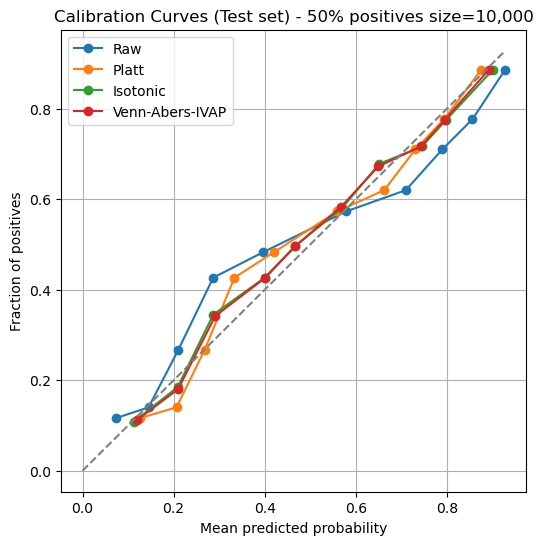

In [33]:
# Size of dataset: 10,000 samples
run_simulation({0: 9500, 1: 500}, title="5% positives size=10,000")

run_simulation({0: 9000, 1: 1000}, title="10% positives size=10,000")

run_simulation({0: 8000, 1: 2000}, title="20% positives size=10,000")

run_simulation({0: 7000, 1: 3000}, title="30% positives size=10,000")

run_simulation({0: 6000, 1: 4000}, title="40% positives size=10,000")

run_simulation({0: 5000, 1: 5000}, title="50% positives size=10,000")


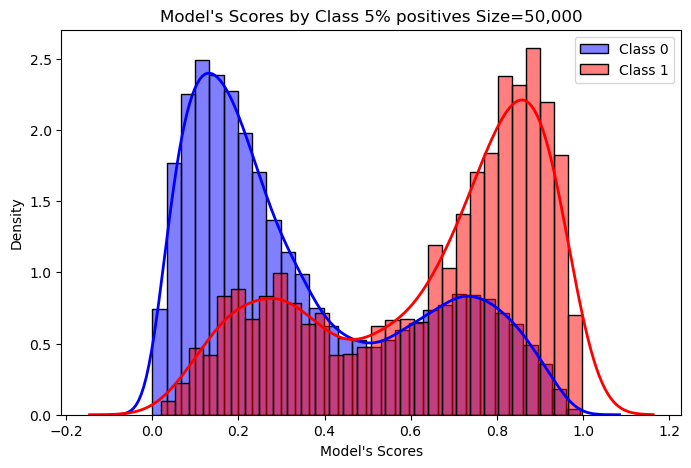


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.562,0.190,0.794,0.314
Platt,0.168,0.043,0.794,0.005
Isotonic,0.167,0.043,0.796,0.000
Venn-Abers-IVAP,0.167,0.043,0.796,0.001



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.564,0.191,0.78,0.314
Platt,0.172,0.044,0.78,0.005
Isotonic,0.173,0.044,0.78,0.004
Venn-Abers-IVAP,0.171,0.044,0.78,0.004


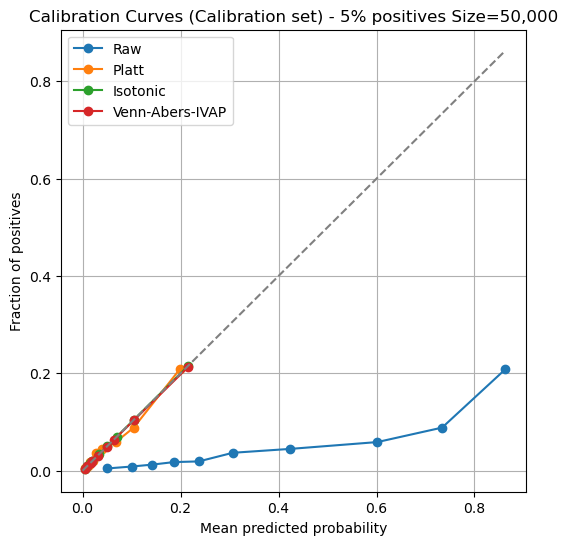

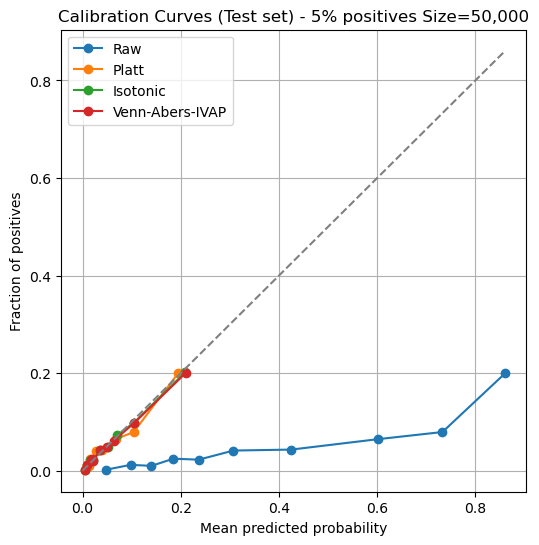

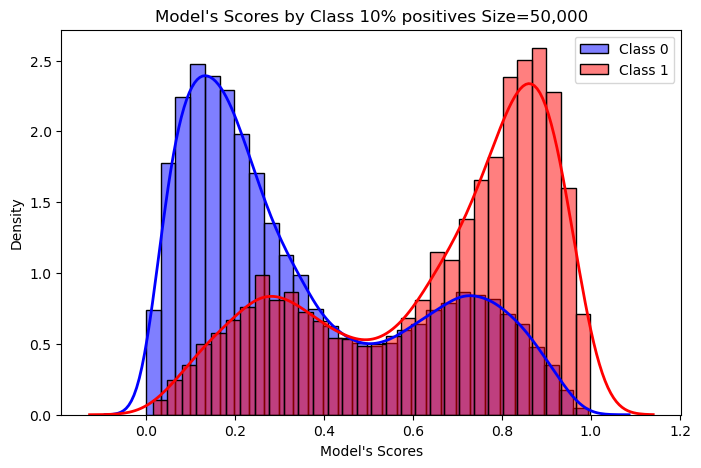


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.566,0.191,0.790,0.281
Platt,0.272,0.078,0.790,0.012
Isotonic,0.270,0.078,0.792,0.000
Venn-Abers-IVAP,0.270,0.078,0.792,0.001



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.554,0.187,0.798,0.277
Platt,0.268,0.077,0.798,0.014
Isotonic,0.267,0.077,0.798,0.006
Venn-Abers-IVAP,0.267,0.077,0.798,0.006


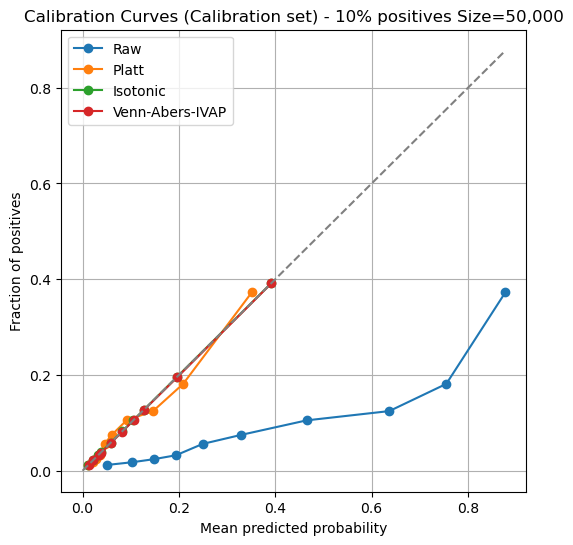

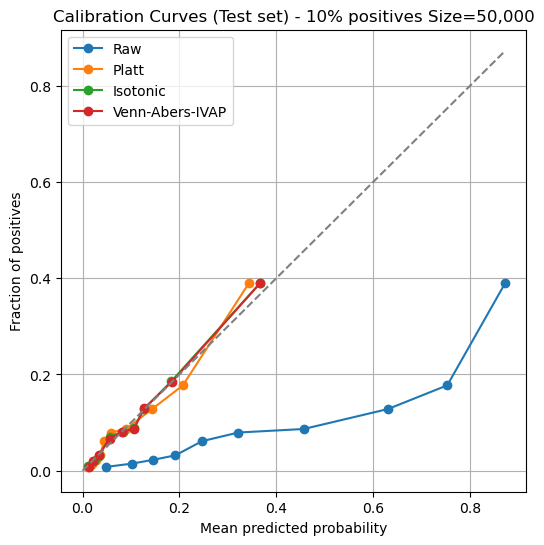

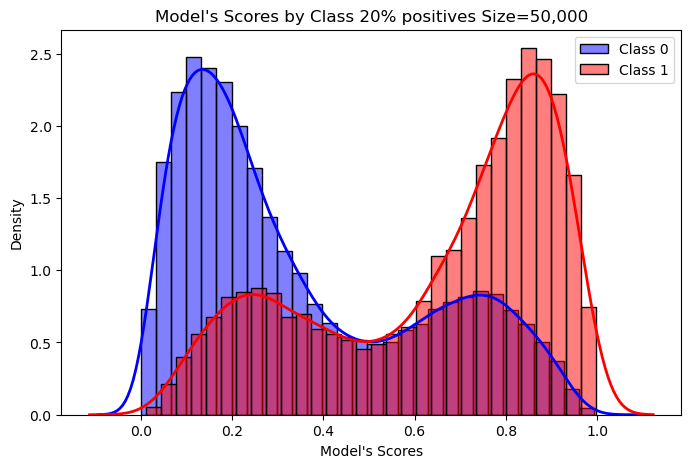


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.568,0.192,0.787,0.210
Platt,0.410,0.129,0.787,0.016
Isotonic,0.408,0.129,0.788,0.000
Venn-Abers-IVAP,0.408,0.129,0.788,0.001



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.557,0.188,0.794,0.207
Platt,0.406,0.128,0.794,0.014
Isotonic,0.405,0.128,0.794,0.008
Venn-Abers-IVAP,0.405,0.128,0.794,0.008


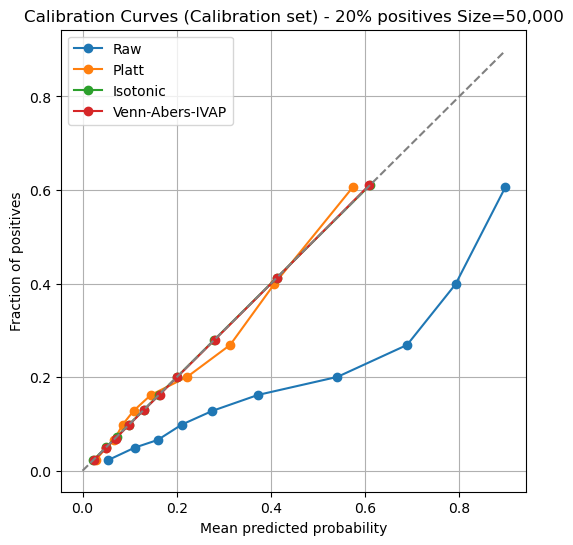

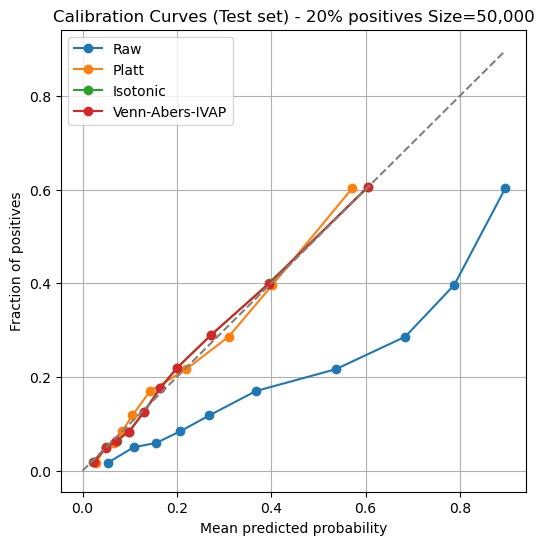

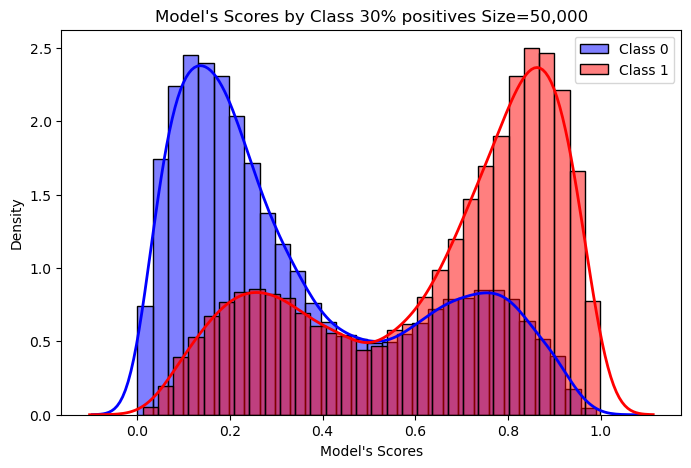


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.566,0.192,0.789,0.140
Platt,0.494,0.163,0.789,0.022
Isotonic,0.490,0.161,0.790,0.000
Venn-Abers-IVAP,0.490,0.162,0.790,0.001



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.558,0.189,0.795,0.139
Platt,0.489,0.161,0.795,0.017
Isotonic,0.493,0.161,0.794,0.011
Venn-Abers-IVAP,0.488,0.161,0.795,0.012


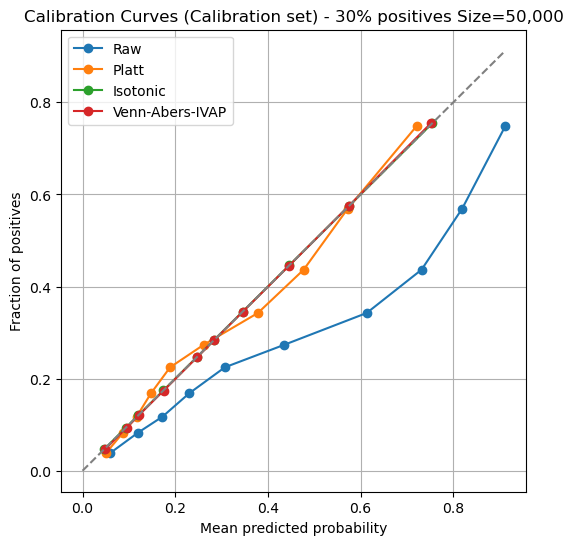

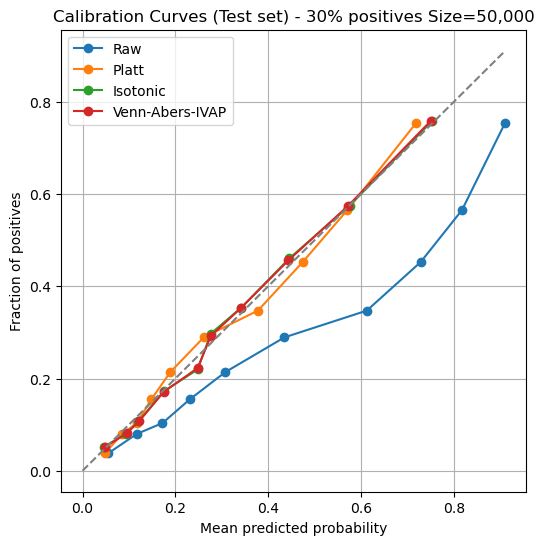

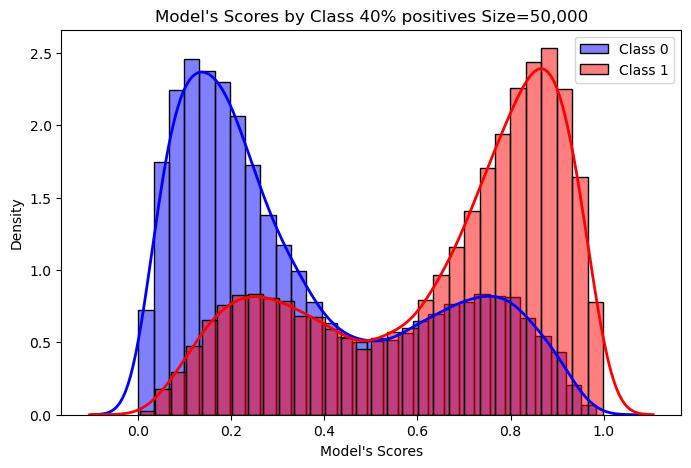


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.564,0.191,0.790,0.071
Platt,0.539,0.181,0.790,0.020
Isotonic,0.536,0.180,0.791,0.000
Venn-Abers-IVAP,0.536,0.180,0.790,0.001



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.559,0.189,0.796,0.073
Platt,0.535,0.179,0.796,0.026
Isotonic,0.537,0.179,0.795,0.013
Venn-Abers-IVAP,0.533,0.179,0.795,0.012


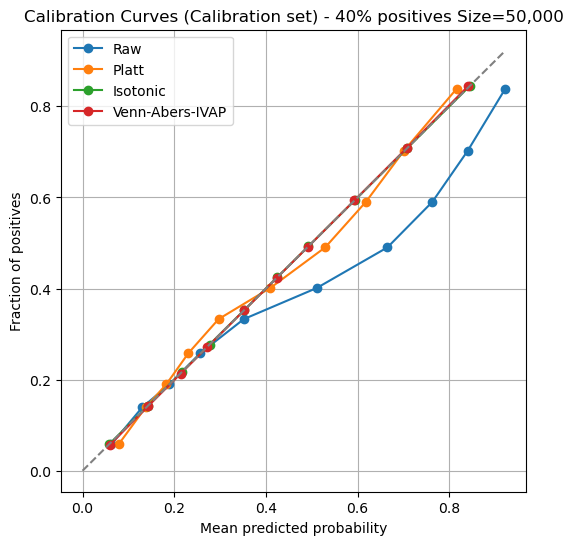

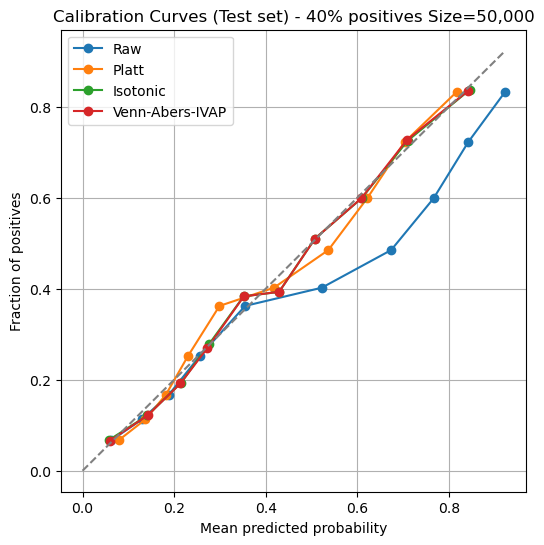

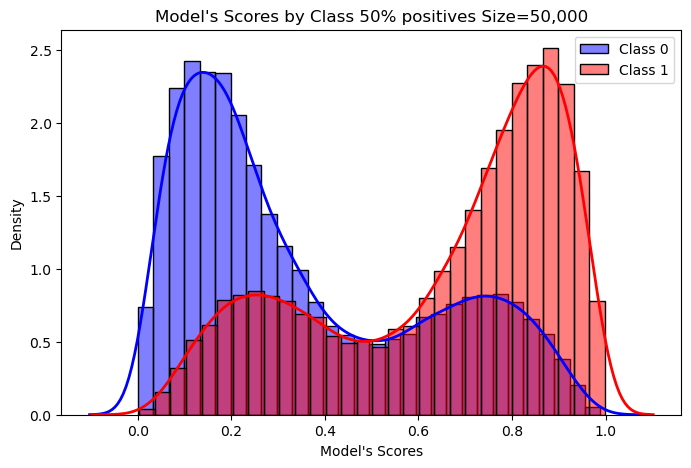


Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.566,0.192,0.789,0.058
Platt,0.556,0.188,0.789,0.020
Isotonic,0.552,0.187,0.790,0.000
Venn-Abers-IVAP,0.552,0.187,0.790,0.001



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.559,0.188,0.794,0.053
Platt,0.550,0.185,0.794,0.015
Isotonic,0.552,0.185,0.794,0.012
Venn-Abers-IVAP,0.550,0.185,0.794,0.012


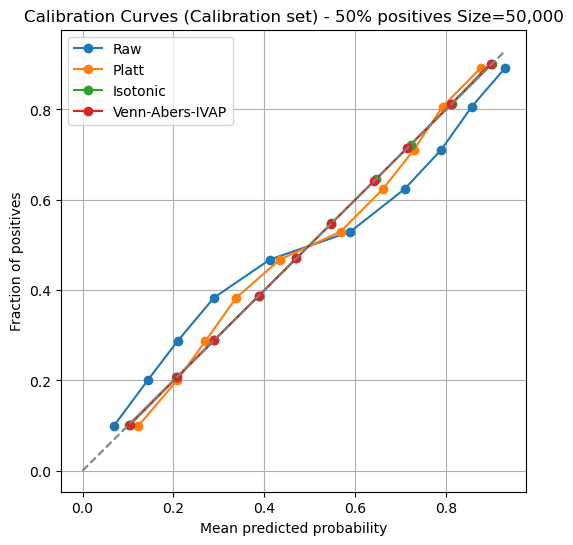

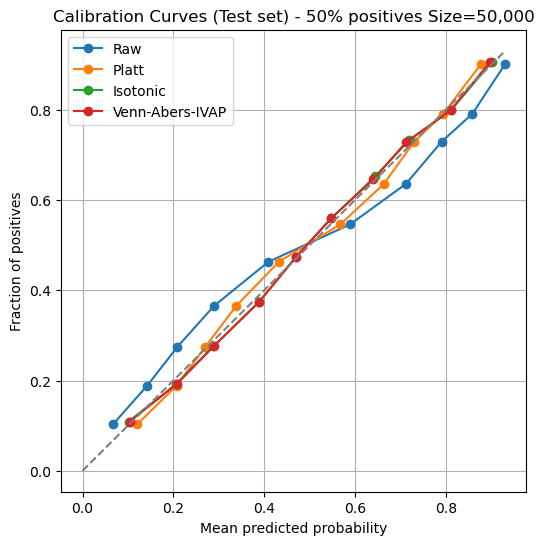

In [34]:
# Size of dataset: 50,000 samples
run_simulation({0: 47500, 1: 2500}, title="5% positives Size=50,000")

run_simulation({0: 45000, 1: 5000}, title="10% positives Size=50,000")

run_simulation({0: 40000, 1: 10000}, title="20% positives Size=50,000")

run_simulation({0: 35000, 1: 15000}, title="30% positives Size=50,000")

run_simulation({0: 30000, 1: 20000}, title="40% positives Size=50,000")

run_simulation({0: 25000, 1: 25000}, title="50% positives Size=50,000")